# Mini project

## Goal of this project
* To get COVID-19 result from home(why? - to avoid spreading COVID-19)

## Plan to attack this project

The result is given based on these three phases
* phase-1: model(NLP) for written text(for example, how the person feel in his/her body) input.
* phase-2: model(ANN) for input data input like: sex, age, went_icu and temperature
* phase-3: model(CNN) for x-ray images

## Materials needed to fulfill the process after this project is done
* A x-ray image (here we assume that there are mobiles which takes x-ray image)
* Internet access

# Importing Libraries and Data

In [49]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import re
import nltk
nltk.download("stopwords")
nltk.download('punkt')
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
#import texthero as hero
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn import tree
import pickle

from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from keras.preprocessing import image
from keras.models import load_model
#import sweetviz as sv
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tsegazabtesfay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tsegazabtesfay/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [50]:
#from google.colab import drive
#drive.mount('/content/gdrive')

<h1><center><u>PHASE-1</u></center></h1>

# Importing and cleaning data

In [51]:
#data = pd.read_csv("/content/gdrive/MyDrive/DATA/metadata.csv")
data = pd.read_csv("./metadata.csv")

In [52]:
data.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

In [53]:
#data_report = sv.analyze(data)
#data_report.show_notebook(layout="vertical", w=880, h=700, scale=0.8)


In [54]:
data = data[["clinical_notes", "date", "RT_PCR_positive"]]

In [55]:
data.head()

,clinical_notes,date,RT_PCR_positive
0,"On January 22, 2020, a 65-year-old man with a ...","January 22, 2020",Y
1,"On January 22, 2020, a 65-year-old man with a ...","January 25, 2020",Y
2,"On January 22, 2020, a 65-year-old man with a ...","January 27, 2020",Y
3,"On January 22, 2020, a 65-year-old man with a ...","January 28, 2020",Y
4,diffuse infiltrates in the bilateral lower lungs,"January 25, 2020",Y


In [56]:
# the goal here to exclude the year before 2019
# and take away the clinical_notes without date to avoid misleading
for i in range(950):
    if isinstance(data["date"][i], str) and (data["date"][i].endswith("19") or data["date"][i].endswith("20") or data["date"][i].endswith("21")):
        pass
    else:
        data = data.drop(i)

In [57]:
# now we drop the date
data  = data[["clinical_notes", "RT_PCR_positive"]]

In [58]:
data.head()

,clinical_notes,RT_PCR_positive
0,"On January 22, 2020, a 65-year-old man with a ...",Y
1,"On January 22, 2020, a 65-year-old man with a ...",Y
2,"On January 22, 2020, a 65-year-old man with a ...",Y
3,"On January 22, 2020, a 65-year-old man with a ...",Y
4,diffuse infiltrates in the bilateral lower lungs,Y


In [59]:
# drop nan in both columns
data = data.dropna(subset=["clinical_notes"])
data = data.dropna(subset=["RT_PCR_positive"])

In [60]:
#data.sort_values("clinical_notes", inplace = True)
data.drop_duplicates(subset ="clinical_notes", keep = False, inplace = True)

In [61]:

def removeMeaninglesWords(x_data):
    """
    Parm: a columns from data-set to be cleaned(has series type)
    Returns: list(str)
    """
    cleaned_clinical_note = []
    # inds characters not in the range: a-zA-Z and whitespace and '
    alphabetic = re.compile(r"[^a-zA-Z\s]")
    # finds single quotes not within a word
    singlequote = re.compile(r"((\W)(?:\B|$)|(?:^|\B)(\W))")
    stop_words = stopwords.words('english')
    for text in x_data:
        new_words = []
        text = unidecode(text) # example: ã'bç becomes abc
        text = re.sub(alphabetic, " ", text) #example: 2"3can't"/ becomes can't
        text = re.sub(singlequote, " ", text) #''' shouldn't '''''' becomes shouldn't
        words = text.lower().split()
        for word in words:
            if (not (word in stop_words) and (word.strip()) and len(word)>1):
                new_words.append(word)
            else:
                continue
        cleaned_clinical_note.append(" ".join(new_words))
    return cleaned_clinical_note


In [62]:
cleaned_data =  removeMeaninglesWords(data["clinical_notes"])

In [63]:
# to show us the difference b/n the orginal and the new on 
def countDifference():
    sum_orginal = 0
    sum_cleaned = 0
    for i in range(len(data)):
        sum_orginal += len(data["clinical_notes"].iloc[i].split(" "))
        sum_cleaned += len(cleaned_data[i].split(" "))
    print("*"*100)
    print("Original words: ", sum_orginal)
    print("Without stopwords & alnum: ", sum_cleaned)
    print("Difference : ", sum_orginal - sum_cleaned)
countDifference()

****************************************************************************************************
Original words:  18500
Without stopwords & alnum:  12260
Difference :  6240


In [64]:
# visualizing uncleaned data(where max appearance is 30)
#hero.visualization.wordcloud(data["clinical_notes"], max_words=30,background_color="black")

In [65]:
# visualizing cleaned data
#hero.visualization.wordcloud(pd.Series(cleaned_data), max_words=30,background_color="brown")

In [66]:
def stemmingNotes(data):
    """
    Parm: list(str)
    Returns: list(str) after stemming
    """
    cleaned_notes = []
    porter = PorterStemmer() # Using the default nltk Porter Stemmer for text normalization
    for text in data:
        token_words = word_tokenize(text)
        stem_sentence = []
        for word in token_words:
            stem_sentence.append(porter.stem(word))
        cleaned_notes.append(" ".join(stem_sentence))
    return cleaned_notes


In [67]:
final_notes = stemmingNotes(cleaned_data)

In [68]:
data["clinical_notes"][:] = final_notes[:]

In [69]:
data["RT_PCR_positive"][936]

'Unclear'

# Data preparation

In [70]:
class CovidResult:
    POSITIVE = "POSITIVE"
    UNCLEAR_ = "UNCLEAR_"

class Notes:
    def __init__(self, clinical_notes, rt_pcr):
        self.clinical_notes = clinical_notes
        self.rt_pcr = rt_pcr
        self.result = self.get_result()
    
    def get_result(self):
        if self.rt_pcr == "Y":
            return CovidResult.POSITIVE
        elif self.rt_pcr == "Unclear":
            return CovidResult.UNCLEAR_

In [71]:
allData = []
for i in range(len(data)):
    allData.append(Notes(data["clinical_notes"].iloc[i], data["RT_PCR_positive"].iloc[i]))
allData[15].result # checking


'POSITIVE'

In [72]:
training, test = train_test_split(allData, test_size = 0.3, random_state=42)

In [73]:
train_x = [x.clinical_notes for x in training]
train_y = [x.result for x in training]
test_x = [x.clinical_notes for x in test]
test_y = [x.result for x in test]

In [74]:
vectorizer = CountVectorizer()
train_x_vector = vectorizer.fit_transform(train_x)
test_x_vector = vectorizer.transform(test_x)

# Models for classification
* testing different models

In [75]:
# Linear svm
clf_svm = svm.SVC(kernel="linear")
clf_svm.fit(train_x_vector, train_y)

# Decision tree
cls_dec = DecisionTreeClassifier()
cls_dec.fit(train_x_vector, train_y)

DecisionTreeClassifier()

In [76]:
# testing two single for both models
print(clf_svm.predict(test_x_vector[0]))
print(cls_dec.predict(test_x_vector[0]))


['UNCLEAR_']
['POSITIVE']


## Evaluation
* see mean accuracy score
* see f1_score
* tuning our models
* chose the best model

In [77]:
# mean accuracy
print(clf_svm.score(test_x_vector, test_y))
print(cls_dec.score(test_x_vector, test_y))


0.76
0.7333333333333333


In [78]:
# f1_score
print(f1_score(test_y, clf_svm.predict(test_x_vector), average=None, labels=[CovidResult.POSITIVE, CovidResult.UNCLEAR_]))
print(f1_score(test_y, cls_dec.predict(test_x_vector), average=None, labels=[CovidResult.POSITIVE, CovidResult.UNCLEAR_]))

[0.83636364 0.55      ]
[0.82142857 0.47368421]


In [79]:
print(train_y.count(CovidResult.UNCLEAR_), test_y.count(CovidResult.UNCLEAR_))
print(train_y.count(CovidResult.POSITIVE), test_y.count(CovidResult.POSITIVE))

47 19
126 56


## Tuning models

In [80]:
# tuning first model
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf_Svm = GridSearchCV(svc, parameters)
clf_Svm.fit(train_x_vector, train_y)
print(clf_Svm.best_score_, clf_Svm.best_params_)

# tuning second model
from sklearn.model_selection import GridSearchCV
from sklearn import tree

parameters = {'max_depth':range(3,20)}
clf_dec = GridSearchCV(tree.DecisionTreeClassifier(), parameters, n_jobs=4)
clf_dec.fit(train_x_vector, train_y)
tree_model = clf_dec.best_estimator_
print(clf_dec.best_score_, clf_dec.best_params_) 



0.8154621848739495 {'C': 10, 'kernel': 'rbf'}
0.8042016806722689 {'max_depth': 11}


## Confusion Matrix

<AxesSubplot:>

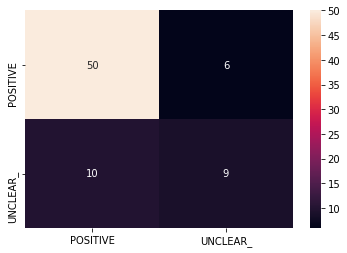

In [81]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib as plt

y_pred = clf_Svm.predict(test_x_vector)

labels = [CovidResult.POSITIVE, CovidResult.UNCLEAR_]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

<AxesSubplot:>

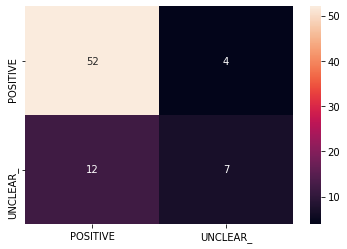

In [82]:
# for 
y_pred = clf_dec.predict(test_x_vector)

labels = [CovidResult.POSITIVE, CovidResult.UNCLEAR_]

cm = confusion_matrix(test_y, y_pred, labels=labels)
df_cm = pd.DataFrame(cm, index=labels, columns=labels)

sn.heatmap(df_cm, annot=True, fmt='d')

# Saving best model

In [83]:
import pickle

with open('./NLP_MODEL.pkl', 'wb') as f:
    pickle.dump(clf_Svm, f)
    
with open('./vectorizer_nlp.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

    
#-__________________________^______________________to load our model_________
#with open('./NLP_MODEL.pkl', 'rb') as f:
#    clf = pickle.load(f)

#with open('./vectorizer_nlp.pkl', 'rb') as f:
#    vectorizer = pickle.load(f)

    
#test_set = ['very quick speeds', "loved the necklace", 'bad']
#new_test = vectorizer.transform(test_set)

#clf.predict(new_test)

<h1><center><u>PHASE-2 and PHASE-3</u></center></h1>

In [84]:
#data = pd.read_csv("/content/gdrive/MyDrive/DATA/metadata.csv") # We we worked on google colab
data = pd.read_csv("./metadata.csv")

In [85]:
data.columns

Index(['patientid', 'offset', 'sex', 'age', 'finding', 'RT_PCR_positive',
       'survival', 'intubated', 'intubation_present', 'went_icu', 'in_icu',
       'needed_supplemental_O2', 'extubated', 'temperature', 'pO2_saturation',
       'leukocyte_count', 'neutrophil_count', 'lymphocyte_count', 'view',
       'modality', 'date', 'location', 'folder', 'filename', 'doi', 'url',
       'license', 'clinical_notes', 'other_notes', 'Unnamed: 29'],
      dtype='object')

In [155]:
class dataProcessing:
    
    def imageProcessing(self, train_location, test_location):
                
        train_datagen = ImageDataGenerator(rescale = 1./255,
                                      shear_range = 0.2,
                                      zoom_range = 0.2,
                                      horizontal_flip = True)
        test_datagen = ImageDataGenerator(rescale = 1./255)
        
        training_set = train_datagen.flow_from_directory(train_location,
                                                        target_size = (64, 64),
                                                        batch_size = 32,
                                                        class_mode = "binary")
        test_set = test_datagen.flow_from_directory(test_location,
                                           target_size = (64, 64),
                                           batch_size = 32,
                                           class_mode = "binary")
        return training_set, test_set  
    
    def dataCleanerForAnn(self, data): # this is only for our case
        df1 = data[["sex", "age", "went_icu", "temperature", "RT_PCR_positive"]]
        df1["sex"] = pd.get_dummies(df1["sex"], drop_first=True)
        df1["went_icu"] = pd.get_dummies(df1["went_icu"], drop_first=True)
        df1["RT_PCR_positive"] = pd.get_dummies(df1["RT_PCR_positive"], drop_first=True)

        df1["temperature"].fillna(df1["temperature"].mean(), inplace=True)
        df1["age"].fillna(df1["age"].mean(), inplace=True)
        return df1
    
    def splittingAndScaling(self, datapath):
        data = pd.read_csv(datapath)
        arrangedData  = self.dataCleanerForAnn(data)
        X = arrangedData.iloc[:, :-1].values
        y = arrangedData.iloc[: ,-1].values 
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        
        return X_train, X_test, y_train, y_test

In [163]:
class buildModel:
    
    def annModel(self, X_train, y_train):
        
        ann = tf.keras.models.Sequential()
        ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
        ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        ann.fit(X_train, y_train, batch_size = 32, epochs = 10)
        return ann
        
    def cnnModel(self, train, test):
        #dataProcessing = dataProcessing()
        #tr, ts = dataProcessing.imageProcessing(train, test)
        
        cnn = tf.keras.models.Sequential()
        cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
        cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
        cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
        cnn.add(tf.keras.layers.Flatten())
        cnn.add(tf.keras.layers.Dense(units=128, activation='relu'))
        cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
        cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
        cnn.fit(x = train, validation_data = test, epochs = 2)
        
        #test
        
        p = "./DATA/test/non/patient00036-study1-view1_frontal.jpg"
        test_image = image.load_img(p, target_size = (64, 64))
        test_image = image.img_to_array(test_image)
        test_image = np.expand_dims(test_image, axis = 0)
        result = cnn.predict(test_image) # cnn == the saved model
        print(tr.class_indices)
        if result[0][0] <= 0.5: # test for the probabilites is less than 10%
            prediction = 'NON-COVID'
        else:
            prediction = 'COVID-19'
        
        return cnn, prediction
    

In [88]:
def predicter(im):
    #train_location = "/content/gdrive/MyDrive/DATA/train" # for google colab
    #test_location = "/content/gdrive/MyDrive/DATA/test"   # for google colab
    
    train_location = "./DATA/train"
    test_location = "./DATA/test"
    
    DP = dataProcessing()
    bM = buildModel()
    train, test  = DP.imageProcessing(train_location, test_location)
    cnn = bM.cnnModel(train, test)
    
    
    test_image = image.load_img(im, target_size = (64, 64))
    test_image = image.img_to_array(test_image)
    test_image = np.expand_dims(test_image, axis = 0)
    result = cnn.predict(test_image) # cnn == the saved model
    
    if result[0][0] <= 0.1: # test for the probabilites is less than 10%
        prediction = 'NON-COVID'
    else:
        prediction = 'COVID-19'

    #print(prediction)
    return prediction
    
    

In [89]:
def testSingleImagePrediction():
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    #test_covid = "/content/gdrive/MyDrive/DATA/test/covid/"
    #test_non_covid = "/content/gdrive/MyDrive/DATA/test/non/"
    test_covid = "./DATA/test/covid/"
    test_non_covid = "./DATA/test/non/"

    Covid_in_test = [i for i in os.listdir(test_covid)]
    nonCovid_in_test = [i for i in os.listdir(test_non_covid)]
    
    test1 = test_covid + random.choice(Covid_in_test)
    test2 = test_non_covid + random.choice(nonCovid_in_test)
    
    imageCovid = mpimg.imread(test1)
    
    plt.imshow(imageCovid)
    plt.title("True image-1 of Covid")
    plt.show()
    
    imageNonCovid = mpimg.imread(test2)
    plt.imshow(imageNonCovid)
    plt.title("True image:2 of Non-Covid")
    plt.show()
    
    return ("Result of image-1 is: %s. Result of image-2 is: %s." %(predicter(test1), predicter(test2)) )
    

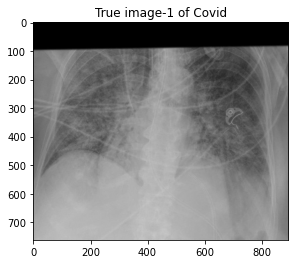

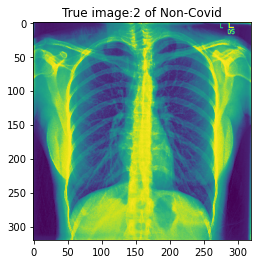

Found 2091 images belonging to 2 classes.
Found 3101 images belonging to 2 classes.
Epoch 1/2
66/66 [==============================] - 42s 623ms/step - loss: 0.2038 - accuracy: 0.9535 - val_loss: 0.1888 - val_accuracy: 0.9674
Epoch 2/2
66/66 [==============================] - 45s 680ms/step - loss: 0.1465 - accuracy: 0.9595 - val_loss: 0.0919 - val_accuracy: 0.9710
Found 2091 images belonging to 2 classes.
Found 3101 images belonging to 2 classes.
Epoch 1/2
66/66 [==============================] - 49s 733ms/step - loss: 0.2209 - accuracy: 0.9610 - val_loss: 0.0827 - val_accuracy: 0.9674
Epoch 2/2
66/66 [==============================] - 46s 697ms/step - loss: 0.1216 - accuracy: 0.9542 - val_loss: 0.0530 - val_accuracy: 0.9726


'Result of image-1 is: COVID-19. Result of image-2 is: COVID-19.'

In [90]:
testSingleImagePrediction()

In [164]:
def saveModel():
    # datapath
    #train_location = "/content/gdrive/MyDrive/DATA/train" 
    #test_location = "/content/gdrive/MyDrive/DATA/test"
    #metaData = "/content/gdrive/MyDrive/DATA/metadata.csv"
    
    train_location = "./DATA/train" 
    test_location = "./DATA/test"
    metaData = "./metadata.csv"
    
    #classes
    DP = dataProcessing()
    models = buildModel()
    
    train, test  = DP.imageProcessing(train_location, test_location)
    X_train, X_test, y_train, y_test = DP.splittingAndScaling(metaData)
    
    print("CNN starts: \n")
    cnnModel = models.cnnModel(train, test)
    #print("ANN starts: \n")
    #annModel = models.annModel(X_train, y_train)
    
    #cnnModel.save("CNN.h5")    
    #annModel.save('ANN_MODEL.h5')

    

In [165]:
saveModel()

Found 2091 images belonging to 2 classes.
Found 3101 images belonging to 2 classes.
CNN starts: 

Epoch 1/2
66/66 [==============================] - 32s 467ms/step - loss: 0.2336 - accuracy: 0.9061 - val_loss: 0.0851 - val_accuracy: 0.9674
Epoch 2/2
66/66 [==============================] - 30s 457ms/step - loss: 0.0899 - accuracy: 0.9667 - val_loss: 0.1243 - val_accuracy: 0.9674
{'covid': 0, 'non': 1}


In [93]:
def NoneReturner():
    print("default")

In [168]:
if __name__ == "__main__":
    #prediction()
    #saveModel()
    #testSingleImagePrediction  #-> Single image tester
    NoneReturner()


default


In [171]:
# test to load the nlp model

with open('./NLP_MODEL.pkl', 'rb') as f:
    nlp_model = pickle.load(f)

with open('./vectorizer_nlp.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

    
test_set = ['very quick speeds']
new_test = vectorizer.transform(test_set)

x  =nlp_model.predict(new_test)
print(x[0])

POSITIVE


In [131]:
import keras
ann_model = keras.models.load_model('ANN_MODEL.h5')

sc = StandardScaler()
r = ann_model.predict(([[1.,23.,1.,38.]]))
print(r[0][0])
ann_model.summary()

0.037608802
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6)                 30        
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 42        
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________


In [167]:
cnn_model = keras.models.load_model('CNN.h5')
p = "./DATA/test/non/patient00036-study1-view1_frontal.jpg"
test_image = image.load_img(p, target_size = (64, 64))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn_model.predict(test_image) # cnn == the saved model

if result[0][0] == 1: # test for the probabilites is less than 10%
    prediction = 'NON-COVID'
else:
    prediction = 'COVID-19'

print(prediction)
print(result[0][0])


NON-COVID
1.0
